<a href="https://colab.research.google.com/github/depresssed-kid/Glass-Classification/blob/main/GlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
#!pip uninstall -y scikit-learn
#!pip install scikit-learn==1.3.1

In [314]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import yellowbrick.classifier as ybc
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.target import ClassBalance

In [315]:
glass_df = pd.read_csv('glass_high_usability.csv')
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [316]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      136 non-null    float64
 1   Na      136 non-null    float64
 2   Mg      136 non-null    float64
 3   Al      136 non-null    float64
 4   Si      136 non-null    float64
 5   K       136 non-null    float64
 6   Ca      136 non-null    float64
 7   Ba      136 non-null    float64
 8   Fe      136 non-null    float64
 9   Type    136 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 10.8 KB


array([[<Axes: title={'center': 'RI'}>, <Axes: title={'center': 'Na'}>,
        <Axes: title={'center': 'Mg'}>],
       [<Axes: title={'center': 'Al'}>, <Axes: title={'center': 'Si'}>,
        <Axes: title={'center': 'K'}>],
       [<Axes: title={'center': 'Ca'}>, <Axes: title={'center': 'Ba'}>,
        <Axes: title={'center': 'Fe'}>],
       [<Axes: title={'center': 'Type'}>, <Axes: >, <Axes: >]],
      dtype=object)

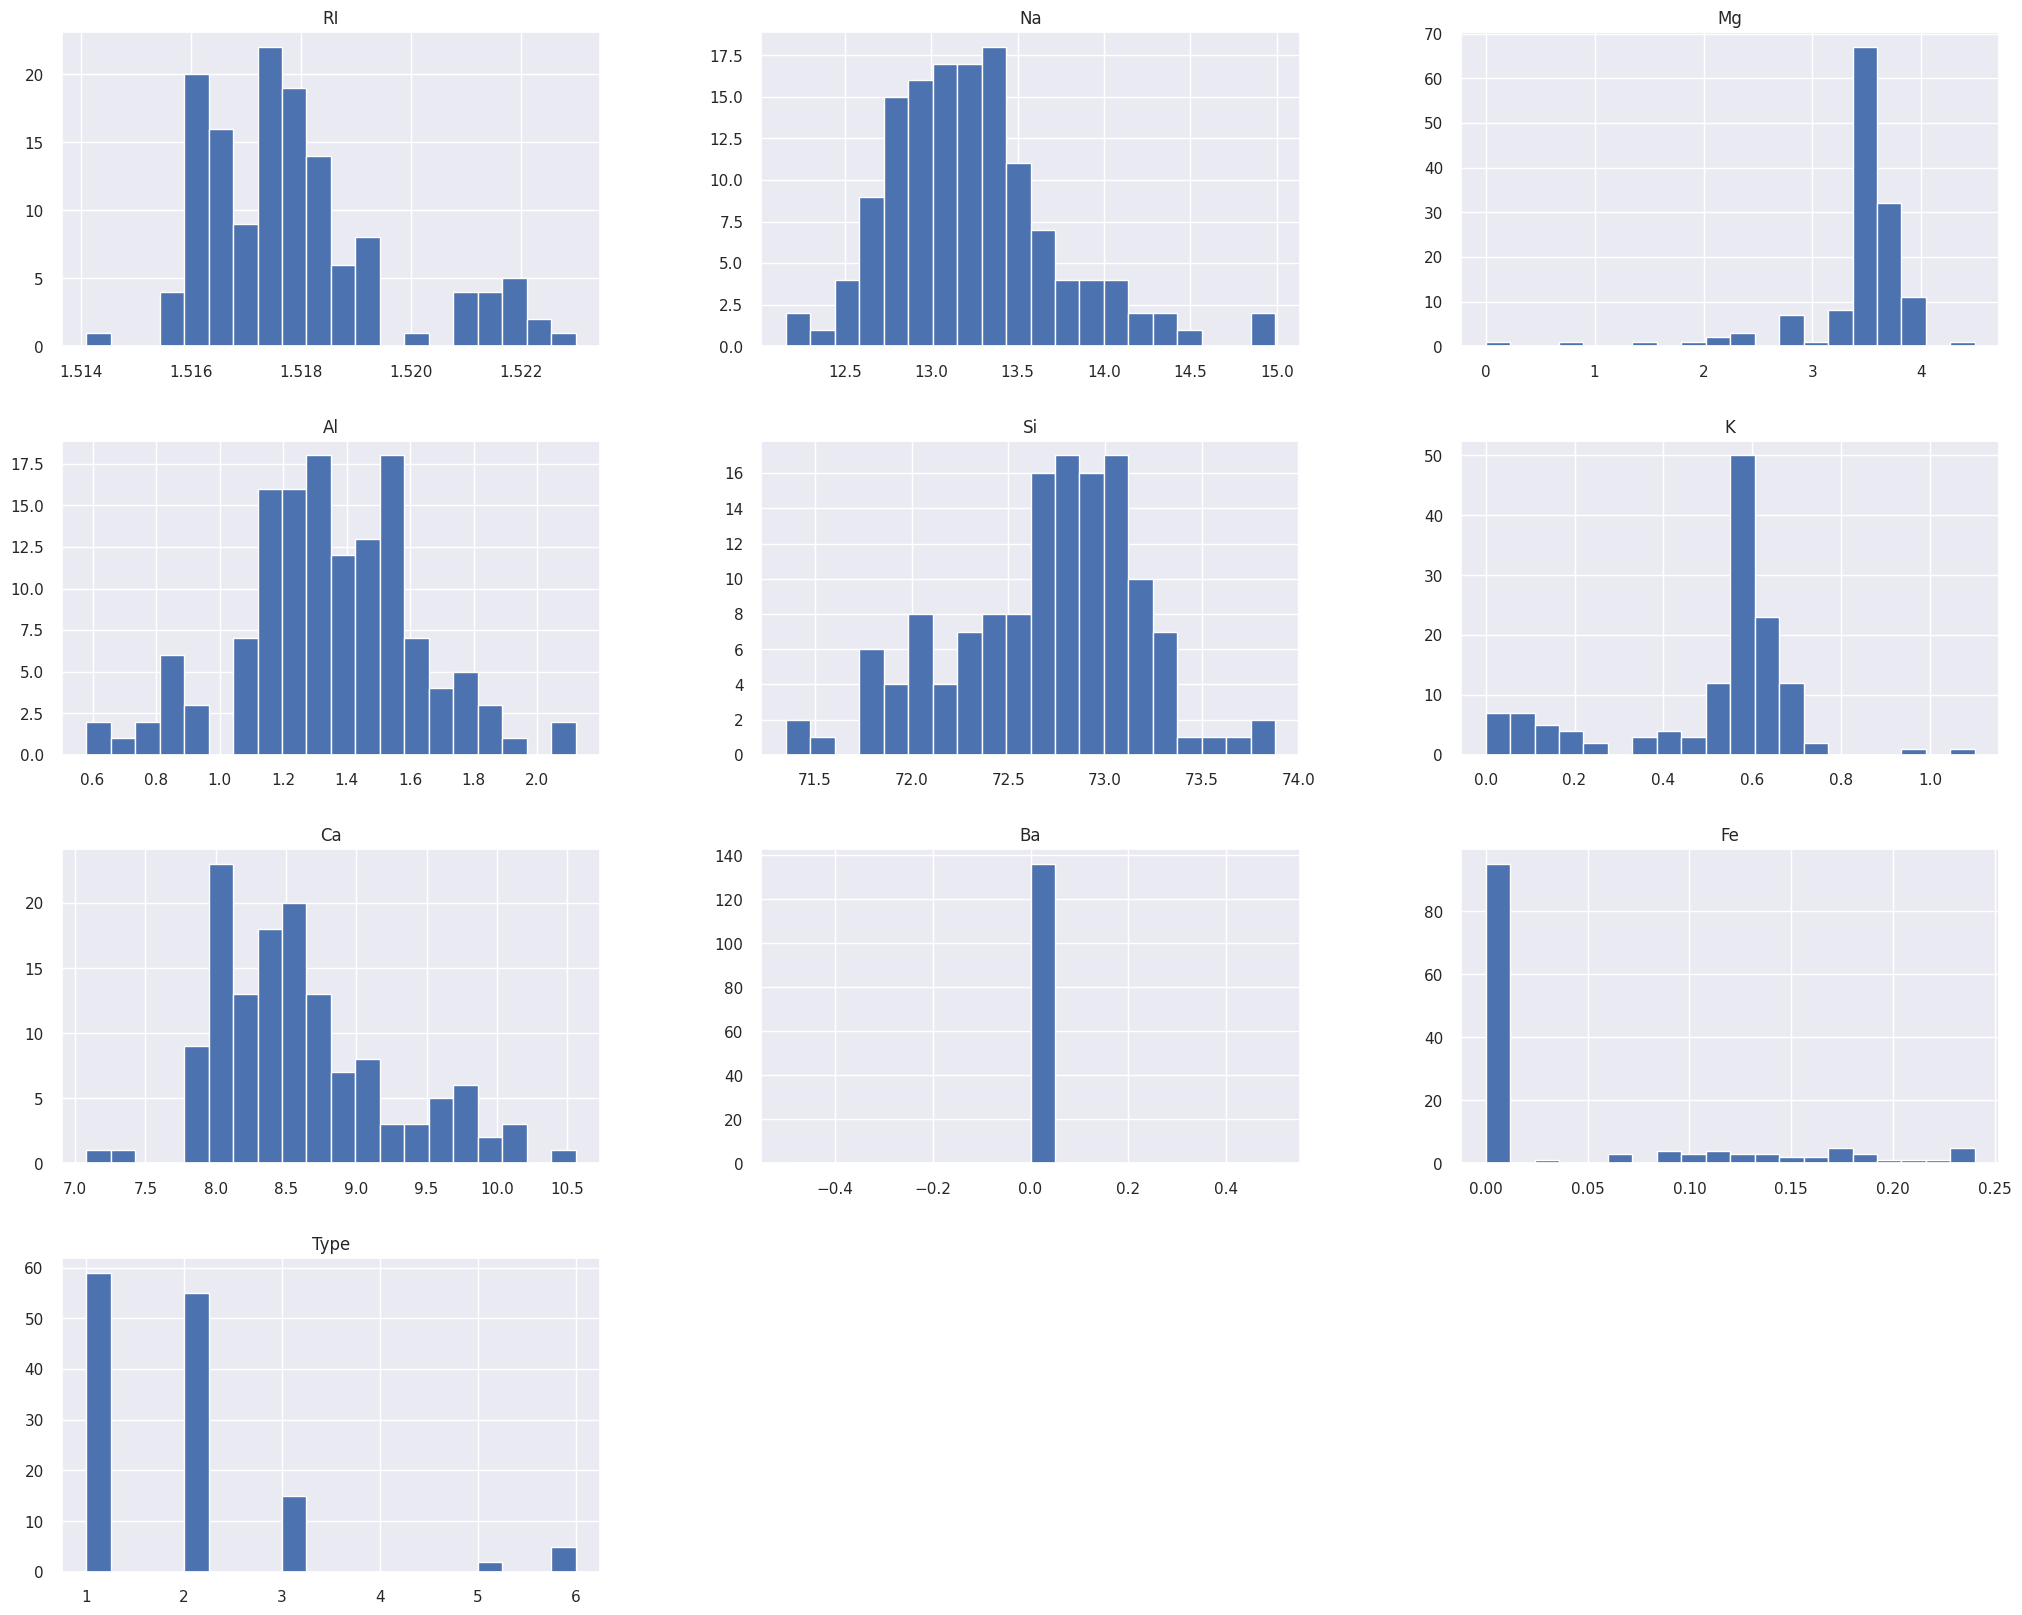

In [317]:
glass_df.hist(bins=20, figsize=(25, 20))

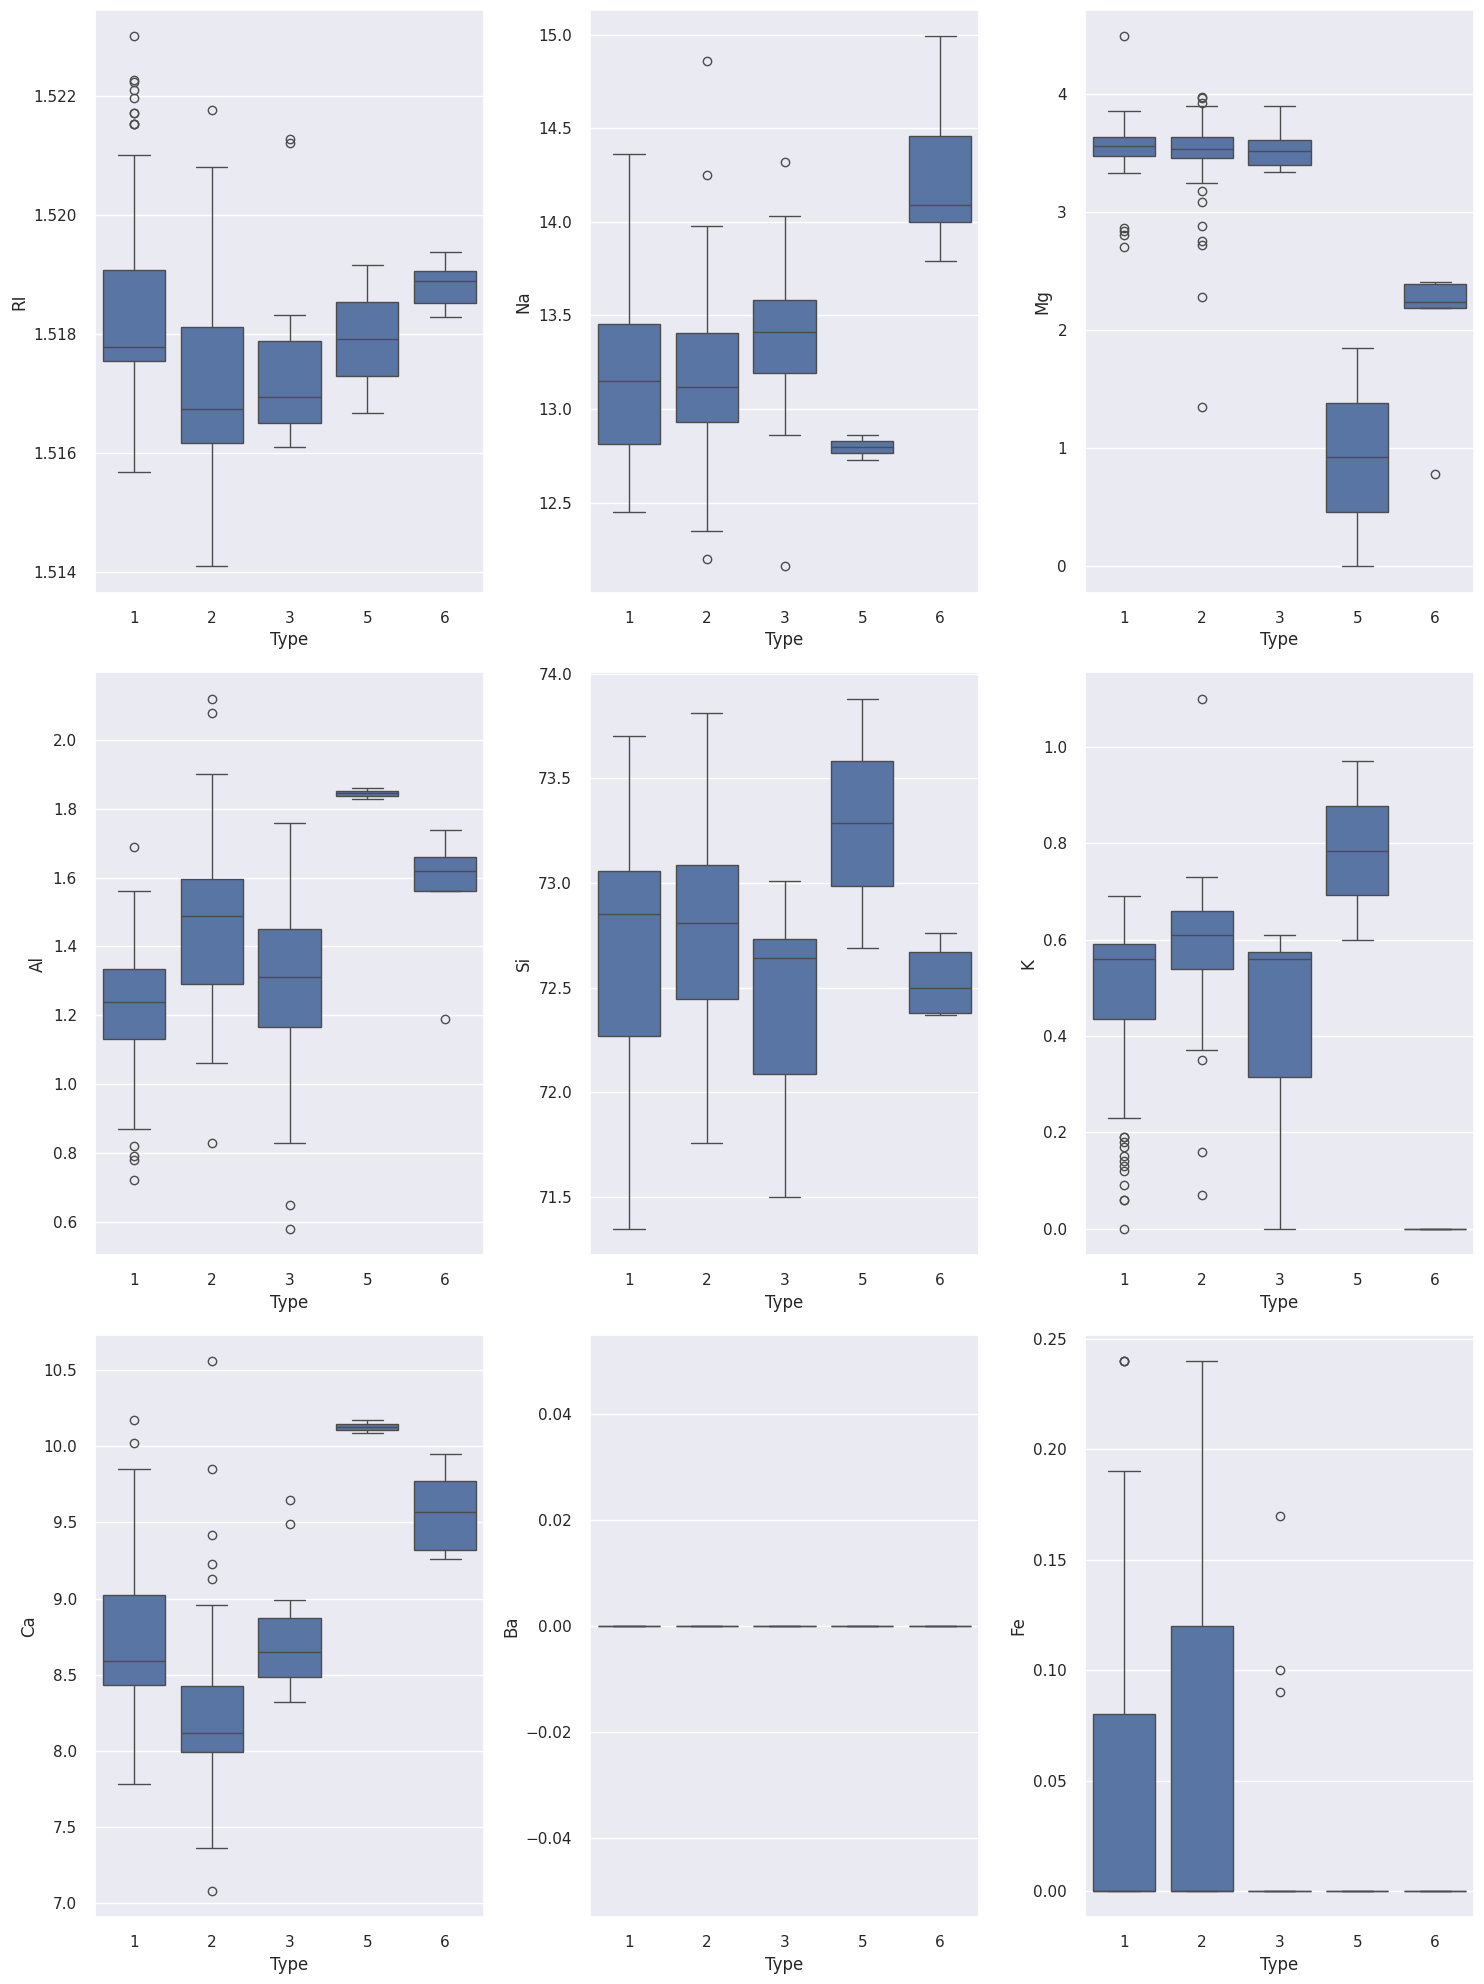

In [318]:
fig, axs = plt.subplots(3, 3, figsize=(15, 20))
axs = axs.flatten()
for i, col in enumerate(glass_df.columns.drop('Type')):
    sns.boxplot(x='Type', y=glass_df[col], data=glass_df, ax=axs[i])
plt.tight_layout()
plt.show()

Since the 'Ba' column has only one value, we assume that it is of no practical use.

In [319]:
glass_df = glass_df.drop("Ba",axis=1)

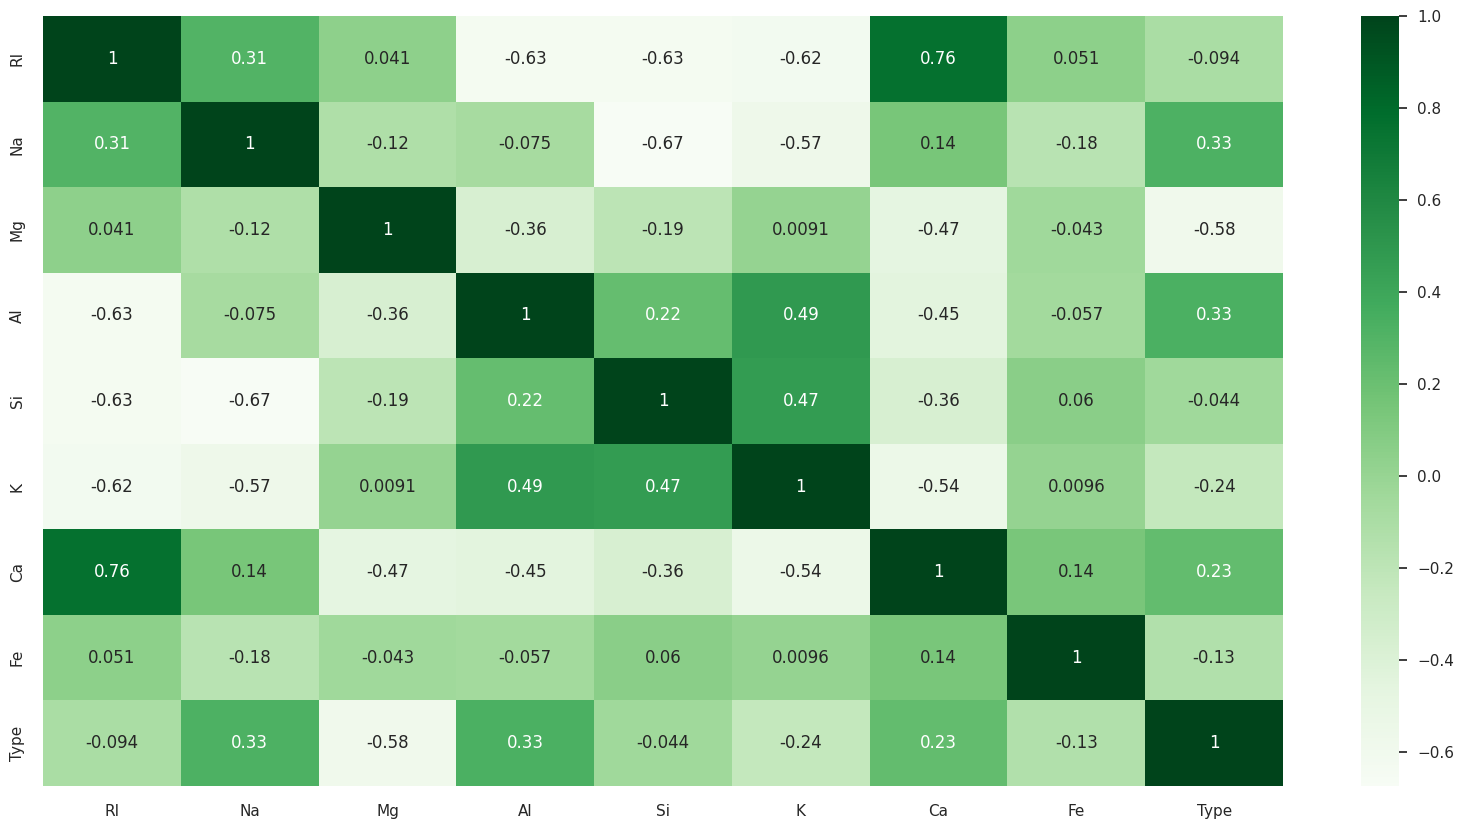

In [320]:
correlation_matrix = glass_df.corr()
sns.heatmap(correlation_matrix, cmap="Greens", annot=True)
plt.show()

Predictors have too much correlation between each other, this may be a sign of multicollinearity.

In [321]:
vif_data = [variance_inflation_factor(glass_df.values, i)
                          for i in range(len(glass_df.columns))]
vif_data

[803269.4213539981,
 14695.736978255669,
 1241.6709704676891,
 233.86488008991333,
 410618.8690381812,
 44.15697499301082,
 8568.397052487648,
 1.4777463598773444,
 7.619564752878066]

VIF shows an incredible level of multicollinearity

In [322]:
glass_df = pd.get_dummies(glass_df, columns=['Type'], drop_first=True)
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Fe,Type_2,Type_3,Type_5,Type_6
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,False,False,False,False
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,False,False,False,False
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,False,False,False,False
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,False,False,False,False
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,False,False,False,False


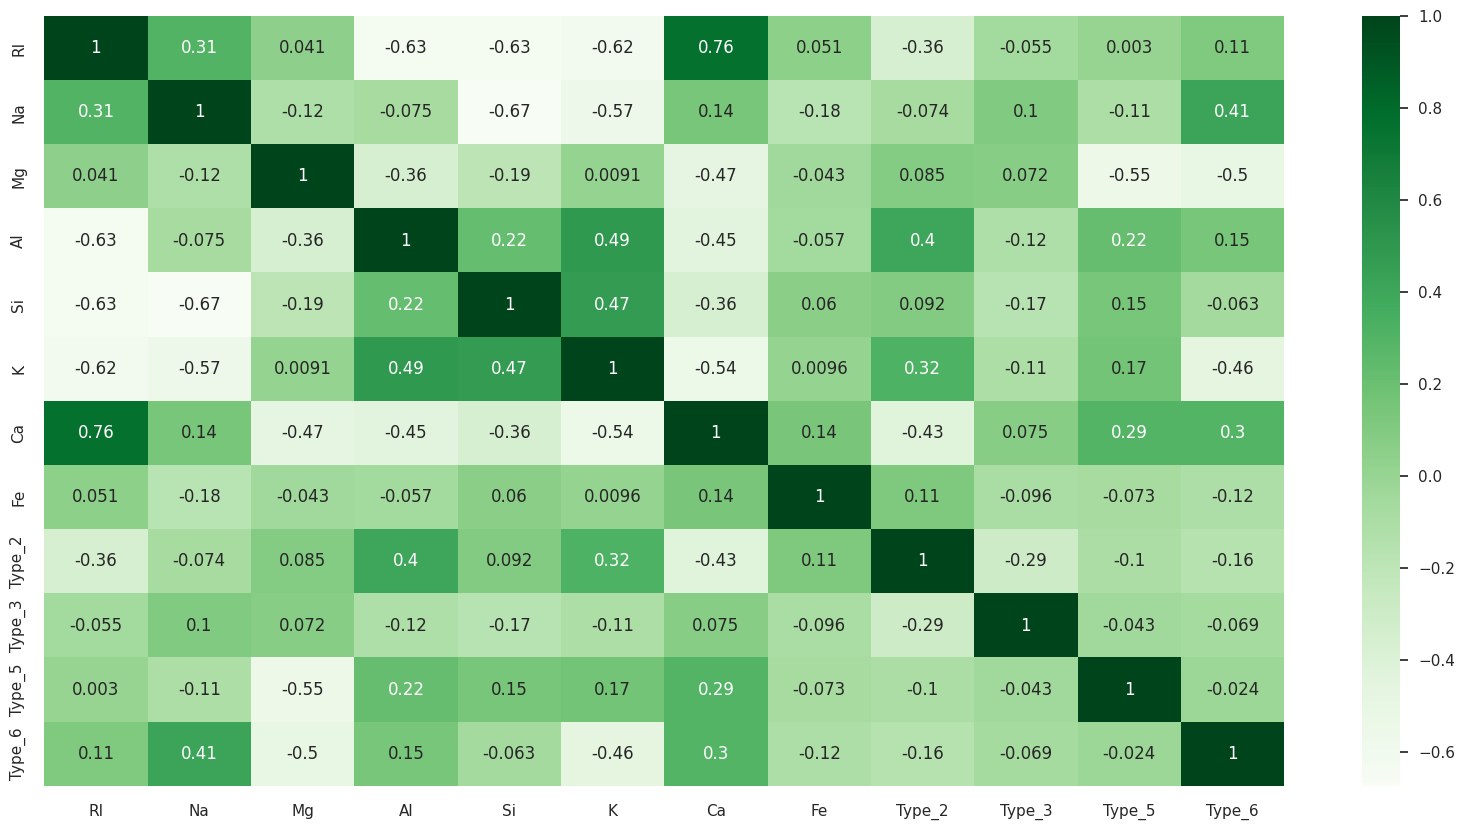

In [323]:
correlation_matrix = glass_df.corr()
sns.set(rc={"figure.figsize": (20, 10)})
sns.heatmap(correlation_matrix, cmap="Greens", annot=True)
plt.show()

In [324]:
# import numpy as np
# glass_df['Type'] = glass_df['Type'] -1
# glass_df['Type'] = np.where(glass_df['Type']>=4,glass_df['Type']-1,glass_df['Type'])
X = glass_df.drop(['Type_2','Type_3','Type_5','Type_6'], axis=1)
y = glass_df[['Type_2','Type_3','Type_5','Type_6']]

# X = glass_df.drop(['Type'], axis=1)
# y = glass_df['Type']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
len(X_train), len(X_test)

(95, 41)

In [325]:
# visualizer = ClassBalance()
# visualizer.fit(y_train, y_test)
# visualizer.poof()

Due to the strong class imbalance, the 'accuracy' metric is not suitable for us

In [326]:
xmodel = xgb.XGBClassifier(random_state=42)
xmodel.fit(X_train, y_train)
xy_pred = xmodel.predict(X_test)
xaccuracy = accuracy_score(y_test, xy_pred)
print(f'XGBModel accuracy: {xaccuracy}')

XGBModel accuracy: 0.7317073170731707
